In [1]:
from skimage import io, transform, color
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image
import os
import math
import torchvision.models as models

from dataLoader import OrganoidDataset
#from conv_model import SimpleConvNet
import matplotlib.pyplot as plt
import copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# global variables

In [163]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

In [3]:
device

device(type='cuda', index=0)

In [4]:
figure_path = '../milestoneReport/figures/'
#path = '../data/CS231n_Tim_Shan_example_data/'
path = '../data/'
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

# load data

In [26]:
label = pd.read_csv(label_path)
new_columns = ['well_id','day','median_pixel_intensity','mw_area_shape','hyst1_area','hyst2_area']
label.columns = new_columns

In [6]:
def get_image_name(well_id,day_id):
    image_name = 'well'+str(well_id).zfill(4)+'_day'+str(day_id).zfill(2)+'_well.png'
    return image_name
def get_well_label(well_id):
    return str(well_id).zfill(4)

In [7]:
label['image_name'] = label[['well_id','day']].apply(lambda x: get_image_name(*x),axis=1)
label['well_label'] = label['well_id'].apply(lambda x: get_well_label(x))

In [8]:
label.head(2)

,well_id,day,median_pixel_intensity,mw_area_shape,hyst1_area,hyst2_area,image_name,well_label
0,0,0,125.0,7830,512,418,well0000_day00_well.png,0000
1,1,0,125.0,8265,3044,3008,well0001_day00_well.png,0001


In [9]:
corrected_labels = label.query("mw_area_shape < 32000")

In [10]:
corrected_labels.loc[:,'has_cell'] = np.int64(corrected_labels['hyst2_area'] > 0)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
def get_day_description(corrected_labels,day):
    df = corrected_labels.query("day == %d"%day)[['well_id','day','well_label','image_name','has_cell']]
    day_suffix = '_' + str(day)
    df = df.rename(columns={'day':'day'+day_suffix, 'has_cell':'has_cell'+day_suffix,'image_name':'image_name'+day_suffix})
    return df

In [12]:
day2wells = get_day_description(corrected_labels,2)
day8wells = get_day_description(corrected_labels,8)
day13wells = get_day_description(corrected_labels,13)

In [13]:
day2wells.shape, day8wells.shape, day13wells.shape

((4712, 5), (4642, 5), (4712, 5))

In [14]:
merged_days = day2wells.merge(day8wells,on=['well_id','well_label']).merge(day13wells,on=['well_id','well_label'])

In [15]:
merged_days.shape

(4510, 11)

In [16]:
#shuffle dataframe
merged_days = merged_days.sample(frac=1).reset_index(drop=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f359ca9c518>,
      dtype=object)

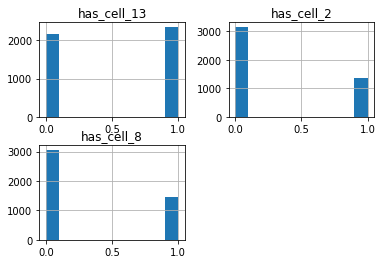

In [17]:
merged_days[['has_cell_2','has_cell_8','has_cell_13']].hist()

In [18]:
merged_days.head(2)

,well_id,day_2,well_label,image_name_2,has_cell_2,day_8,image_name_8,has_cell_8,day_13,image_name_13,has_cell_13
0,2503,2,2503,well2503_day02_well.png,0,8,well2503_day08_well.png,0,13,well2503_day13_well.png,0
1,3318,2,3318,well3318_day02_well.png,0,8,well3318_day08_well.png,0,13,well3318_day13_well.png,1


## normalization

In [5]:
def update_mean(x, x_bar_prev, n):
  return x_bar_prev + (x - x_bar_prev)/n

def update_sum_square_diff(x, ssd_prev, x_bar_prev, x_bar_curr):
  return ssd_prev + (x - x_bar_prev)*(x - x_bar_curr)

In [6]:
def get_mean_std(image_names):
    #image_names = merged_days['image_name_1']
    x_bar_curr = 0.0
    x_bar_prev = 0.0
    ssd_curr = 0.0
    n = 0
    for index in range(len(image_names)):
        img_name = image_names[index]
        img_loc = os.path.join(path, img_name)
      # skimage.io.imread returns a numpy array
        image = io.imread(img_loc)
      # convert to grey scale
        image = color.rgb2gray(image)
        for i, x in np.ndenumerate(image):
            n = n + 1
            x_bar_prev = x_bar_curr
            x_bar_curr = update_mean(x, x_bar_prev, n)
            ssd_curr = update_sum_square_diff(x, ssd_curr, x_bar_prev, x_bar_curr)
    return x_bar_curr, ssd_curr/n

In [7]:
mean_sd_dict = {}

In [50]:
#mean_sd_dict[1] = [day1_mean, day1_std]

In [51]:
day8_mean, day8_std = get_mean_std(merged_days['image_name_8'])
day2_mean, day2_std = get_mean_std(merged_days['image_name_2'])

In [80]:
mean_sd_dict[2] = [day2_mean, np.sqrt(day2_std)]
mean_sd_dict[8] = [day8_mean, np.sqrt(day8_std)]

In [81]:
mean_sd_dict

{2: [0.49286571111372995, 0.16116063273637155],
 8: [0.5374226001116033, 0.15356177002318155]}

In [82]:
mean_sd_df = pd.DataFrame.from_dict(mean_sd_dict,orient='index',columns=['mean','std'])

In [83]:
mean_sd_df.to_csv("mean_sd_for_4510images.csv")

## data loader

In [133]:
class OrganoidMultipleDataset(data.Dataset):
    'dataset class for microwell organoid images'
    def __init__(self, path2files, image_names, Y, mean_sd_dict, transforms=None):
        for k, image_name in image_names.items():
            assert len(image_name) == len(Y)
        self.path = path2files
        self.image_names = image_names
        self.Y = Y
        self.mean_sd_dict = mean_sd_dict
        self.transforms = transforms
    def __len__(self):
        return len(self.Y)
    def getXimage(self, index):
        all_images_list = []
        for day,img_names in self.image_names.items():
            #print(day, "   ", index)
            
            img_name = img_names[index]
            img_loc = os.path.join(self.path, img_name)
            image = io.imread(img_loc)
            mean, sd = self.mean_sd_dict[day]
            image = np.true_divide(color.rgb2gray(image) - mean, sd)
            all_images_list.append(image)
        images = np.array(all_images_list)
        return torch.from_numpy(images).float()
    def getY(self, index):
        Y = self.Y[index]
        return torch.from_numpy(np.asarray(self.Y[index], dtype=float)).float()
    def __getitem__(self, index):
        X = self.getXimage(index)
        y = self.getY(index)
        if self.transforms is not None:
            X = self.transforms(X)
        return X, y

In [164]:
training_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_train_v2.csv')
validation_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_validation_v2.csv')
test_labels = pd.read_csv('../data_description/A1_A2_C1_filtered_test_v2.csv')

# training_labels = pd.read_csv('../data_description/A1_A2_A3_A4_C1_filtered_train_v2.csv')
# validation_labels = pd.read_csv('../data_description/A1_A2_A3_A4_C1_filtered_validation_v2.csv')

# training_labels = pd.read_csv('../data_description/A1_A2_A3_A4_C1_C2_filtered_train_v2.csv')
# validation_labels = pd.read_csv('../data_description/A1_A2_A3_A4_C1_C2_filtered_validation_v2.csv')

In [165]:
training_labels.shape,validation_labels.shape,test_labels.shape

((6514, 60), (814, 60), (815, 60))

In [136]:
# validation_labels=merged_days[:4059].reset_index()
# training_labels = merged_days[4059:].reset_index()



In [137]:
# training_image_names = {2:training_labels['image_name_2'],8:training_labels['image_name_8']}
# validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8']}
# test_image_names = {2:test_labels['image_name_2'],8:test_labels['image_name_8']}

In [138]:
training_image_names = {2:training_labels['image_name_2'],8:training_labels['image_name_8'], 5:training_labels['image_name_5']}
validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8'],5:validation_labels['image_name_5']}

In [139]:
# training_image_names = {2:training_labels['image_name_2'],8:training_labels['image_name_8']}
# validation_image_names = {2:validation_labels['image_name_2'],8:validation_labels['image_name_8']}
training_y = training_labels['has_cell_13']
validation_y = validation_labels['has_cell_13']
test_y = test_labels['has_cell_13']


In [140]:
# mean_sd_dict = {2: [0.49439774802337344, 0.16087996922691195],
#  8: [0.5177020917650417, 0.15714445907773483]          }

In [141]:
mean_sd_dict = {2: [0.49439774802337344, 0.16087996922691195],
 8: [0.5177020917650417, 0.15714445907773483],
 5: [0.5013496452715945, 0.1605951051365687],              }

In [144]:
train_set = OrganoidMultipleDataset(path2files = path, image_names = training_image_names, Y = training_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)
validation_set = OrganoidMultipleDataset(path2files = path, image_names = validation_image_names, Y = validation_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)
test_set = OrganoidMultipleDataset(path2files = path, image_names = test_image_names, Y = test_labels['has_cell_13'],mean_sd_dict=mean_sd_dict)



### data augmentation 

In [122]:
import torchvision.transforms as transforms
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(158, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    
])

In [123]:
train_set = OrganoidMultipleDataset(path2files = path, image_names = training_image_names, Y = training_labels['has_cell_13'],mean_sd_dict=mean_sd_dict,transforms=transform_train)
validation_set = OrganoidMultipleDataset(path2files = path, image_names = validation_image_names, Y = validation_labels['has_cell_13'],mean_sd_dict=mean_sd_dict,transforms=transform_train)
test_set = OrganoidMultipleDataset(path2files = path, image_names = test_image_names, Y = test_labels['has_cell_13'],mean_sd_dict=mean_sd_dict,transforms=transform_train)

### data loader 

In [145]:
training_generator = data.DataLoader(train_set, **params)
validation_generator = data.DataLoader(validation_set, **params)
test_generator = data.DataLoader(test_set, **params)

# Model

In [96]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [97]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [98]:
def check_accuracy_part34(loader, model,dataset='validation'):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print(dataset + 'accuracy: ', acc)
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, preds

In [155]:
def train_part34(model, optimizer, epochs=1,lr_scheduler=None):
    best_model = None
    best_validation_accuracy = -1
    
    losses = []
    validation_accuracy = []
    training_accuracy = []
    prediction = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU

        
    for e in range(epochs):
        print('epoch:',e)
        
        if lr_scheduler is not None:
            lr_scheduler.step()
            print('LR:', lr_scheduler.get_lr())

        for t, (x, y) in enumerate(training_generator):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            


            if t % print_every == 0:
                l = loss.item()
                losses.append(l) 

                print('Iteration %d, loss = %.4f' % (t, l))
                train_acc, _ = check_accuracy_part34(training_generator, model, dataset='training')
                training_accuracy.append(train_acc)
                validation_acc, preds = check_accuracy_part34(validation_generator, model,dataset='validation')
                validation_accuracy.append(validation_acc)
                prediction.append(preds)
                
                if validation_acc > best_validation_accuracy:
                    best_validation_accuracy = validation_acc
                    best_model = copy.deepcopy(model)


                print()

        
                        
#     checkpoint = {'model': best_model,
#                 'state_dict': model.state_dict()
#                }

#     torch.save(checkpoint, 'classification_checkpoint.pth')
    #torch.save(best_model.state_dict(), 'classification_model.pth')
    return losses, validation_accuracy, training_accuracy, prediction,best_model

In [156]:
def get_out_channels(in_channels,kernal_size,padding,stride = 1,max_pool=False):
    if max_pool:
        denominator = 2*stride
    else:
        denominator = stride
    out = math.floor((in_channels + 2*padding - kernal_size)/denominator) + 1  
    return out

### Shan's model

In [21]:
# dim1 = get_out_channels(in_channels=193,kernal_size=5,padding=2,stride = 1,max_pool=True)
# dim2 = get_out_channels(in_channels=dim1,kernal_size=3,padding=1,stride = 1,max_pool=True)
# dim3 = get_out_channels(in_channels=dim2,kernal_size=3,padding=1,stride = 1,max_pool=False)

In [29]:
in_channels = 2 
channel_1 = 32
channel_2 = 16
channel_3 = 8
out_size = 2
image_size = int(193/2/2)
image_size = 193
model = nn.Sequential(
    nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,bias=True),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    nn.MaxPool2d(2),
    
    nn.Dropout(),
    Flatten(),
    nn.Linear(256*6*6, out_size),
)

In [23]:
in_channels = 2 
channel_1 = 32
channel_2 = 16
channel_3 = 8
out_size = 2
image_size = int(193/2/2)
image_size = 193
model = nn.Sequential(
    nn.Conv2d(in_channels=in_channels,out_channels=32,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,bias=True),
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    nn.MaxPool2d(2),
    
    nn.Dropout(),
    Flatten(),
    nn.Linear(256*6*6, 4096),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(4096, out_size),
)

### Tim's model

In [71]:
in_channels = 2
out_size = 2
layer1channels = 64
layer2channels = 32 
layer3channels = 16
in_size = 193

layer1dim = math.floor((in_size + 2 *0 - 1*(2 - 1) - 1)/1) + 1 # size after convs                                                                                                                 
layer1dim = math.floor((layer1dim + 2*0 - 1*(2 - 1) - 1)/2) + 1 # size after max pool     
layer2dim = math.floor((layer1dim + 2 *1 - 1*(3 - 1) - 1)/1) + 1 # size after convs
layer2dim = math.floor((layer2dim + 2*0 - 1*(2 - 1) - 1)/2) + 1 # size after max pool
layer3dim = math.floor((layer2dim + 2 *1 - 1*(3 - 1) - 1)/1) + 1 # size after convs                                                                                                                
layer3dim = math.floor((layer3dim + 2*0 - 1*(2 - 1) - 1)/2) + 1 # size after max pool   
                    
model = nn.Sequential(
    nn.Conv2d(in_channels, layer1channels,kernel_size=2, stride=1, padding=0),
    nn.BatchNorm2d(layer1channels),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
                    
    nn.Conv2d(layer1channels, layer2channels,kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(layer2channels),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
                    
    nn.Conv2d(layer2channels, layer3channels,kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(layer3channels),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    
    Flatten(),
    nn.Linear(in_features = layer3dim*layer3dim*layer3channels, out_features = layer3dim*layer3dim*layer3channels),
    nn.Linear(in_features = layer3dim*layer3dim*layer3channels, out_features = out_size),
)

    
    
    
    

### Alex Net 

In [161]:
# in_channels = 2 
# channel_1 = 32
# channel_2 = 16
# channel_3 = 8
# out_size = 2
# image_size = 193
# model = nn.Sequential(
#     nn.Conv2d(2, 64, kernel_size=11, stride=4, padding=2),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2),
#     nn.Conv2d(64, 192, kernel_size=5, padding=2),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2),
#     nn.Conv2d(192, 384, kernel_size=3, padding=1),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(384, 256, kernel_size=3, padding=1),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(256, 256, kernel_size=3, padding=1),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2), 
#     Flatten(),
#     nn.Linear(256*image_size*image_size, out_size,bias=True),
# )

### Pretrained Resnet

In [152]:
resnet18 = models.resnet18()
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

### train model

In [42]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [153]:
print_every = 100
epoches = 10
learning_rate = 0.1

optimizer =optim.Adam(model.parameters(), lr=learning_rate)

losses,validation_accuracy, training_accuracy,prediction,best_model = train_part34(model, optimizer,epochs=epoches)

epoch: 0
Iteration 0, loss = 0.6932


KeyboardInterrupt: 

# load checkpoint for prediction

In [35]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('classification_checkpoint.pth')

In [58]:
for x, y in test_generator:
    x = x.to(device=device, dtype=dtype)
    prediction = model(x)

In [61]:
prediction

torch.Size([15, 2])

### Train Pretrain ResNet 

In [20]:
# print_every = 100
# epoches = 10
# learning_rate = 1e-4

# optimizer =optim.Adam(model.parameters(), lr=learning_rate)

# losses,validation_accuracy, training_accuracy,prediction = train_part34(model, optimizer,epochs=epoches)

epoch: 0
Iteration 0, loss = 0.7584
trainingaccuracy:  0.5646340414552335
validationaccuracy:  0.5774260151410874

Iteration 100, loss = 0.4217
trainingaccuracy:  0.8415756429001462
validationaccuracy:  0.7825189263592567

epoch: 1
Iteration 0, loss = 0.4362
trainingaccuracy:  0.8403715489808204
validationaccuracy:  0.7818306951135582

Iteration 100, loss = 0.3915
trainingaccuracy:  0.9139072847682119
validationaccuracy:  0.7660013764624914

epoch: 2
Iteration 0, loss = 0.1957
trainingaccuracy:  0.8785585275651501
validationaccuracy:  0.7625602202339986

Iteration 100, loss = 0.1992
trainingaccuracy:  0.9476219145093318
validationaccuracy:  0.7639366827253957

epoch: 3
Iteration 0, loss = 0.1562
trainingaccuracy:  0.9523522834781113
validationaccuracy:  0.7584308327598073

Iteration 100, loss = 0.1557
trainingaccuracy:  0.9648232562139847
validationaccuracy:  0.748107364074329

epoch: 4
Iteration 0, loss = 0.0651
trainingaccuracy:  0.9576846994065538
validationaccuracy:  0.756366139022

### Train Tim's model

In [62]:
# print_every = 100
# epoches = 25
# learning_rate = 1e-4

# optimizer =optim.Adam(model.parameters(), lr=learning_rate)

# losses,validation_accuracy, training_accuracy,prediction = train_part34(model, optimizer,epochs=epoches)

### Train with exp lr decay 

In [167]:


print_every = 100
epoches = 10
learning_rate = 0.001

optimizer =optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

losses,validation_accuracy, training_accuracy,prediction = train_part34(model, optimizer,epochs=epoches,lr_scheduler=lr_scheduler)

epoch: 0
LR: [0.001]
Iteration 0, loss = 0.5537
trainingaccuracy:  0.7072459318391158
validationaccuracy:  0.6756756756756757

epoch: 1
LR: [0.001]
Iteration 0, loss = 0.5181
trainingaccuracy:  0.7095486644151059
validationaccuracy:  0.6793611793611793

epoch: 2
LR: [0.001]
Iteration 0, loss = 0.4375
trainingaccuracy:  0.724286152901443
validationaccuracy:  0.6928746928746928

epoch: 3
LR: [0.001]
Iteration 0, loss = 0.4741
trainingaccuracy:  0.7456248081056187
validationaccuracy:  0.730958230958231

epoch: 4
LR: [1e-05]
Iteration 0, loss = 0.5481
trainingaccuracy:  0.7520724593183912
validationaccuracy:  0.726044226044226

epoch: 5
LR: [0.0001]
Iteration 0, loss = 0.4729
trainingaccuracy:  0.7605158120970218
validationaccuracy:  0.7346437346437347

epoch: 6
LR: [0.0001]
Iteration 0, loss = 0.4212
trainingaccuracy:  0.7654283082591342
validationaccuracy:  0.7493857493857494

epoch: 7
LR: [0.0001]
Iteration 0, loss = 0.4450
trainingaccuracy:  0.7646607307338041
validationaccuracy:  0.74

ValueError: too many values to unpack (expected 4)

In [ ]:
# print_every = 100
# epoches = 10
# learning_rate = 0.01

# lambda1 = lambda epoch: epoch // 1
# lambda2 = lambda epoch: 0.95 ** epoch


# optimizer =optim.Adam(model.parameters(), lr=learning_rate)
# lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])

# losses,validation_accuracy, training_accuracy,prediction = train_part34(model, optimizer,epochs=epoches,lr_scheduler=lr_scheduler)

# plotting

In [1]:
def plot_loss(losses=losses):
    fig = plt.figure()
    plt.subplot(2, 1, 2)
    plt.plot(losses, '.-')
    plt.title("Loss history")
    plt.ylim(0)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def plot_accuracies(training_accuracy=training_accuracy, validation_accuracy=validation_accuracy):
    fig = plt.figure()
    plt.subplot(2, 1, 2)
    plt.plot(training_accuracy, '.-')
    plt.plot(validation_accuracy, '.-')
    plt.title("training and validation accuracy")
    plt.ylim(0,1)
    plt.legend(['train', 'val'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.show()
    #fig.savefig(figure_path+'train_val_MSE.pdf')

NameError: name 'losses' is not defined

In [33]:
def print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy):
    loss = min(losses)
    val_acc = max(validation_accuracy)
    train_acc = max(training_accuracy)
    print("Minimum loss: %.4f"%loss )
    print("best training accuracy %.4f"%train_acc)
    print("Best validation accuracy %.4f"%val_acc)
    return loss, val_acc, train_acc

In [34]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

### pretrain 6k with data augmentation for 158 randomcrop

In [130]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.3005
best training accuracy 0.8571
Best validation accuracy 0.7297


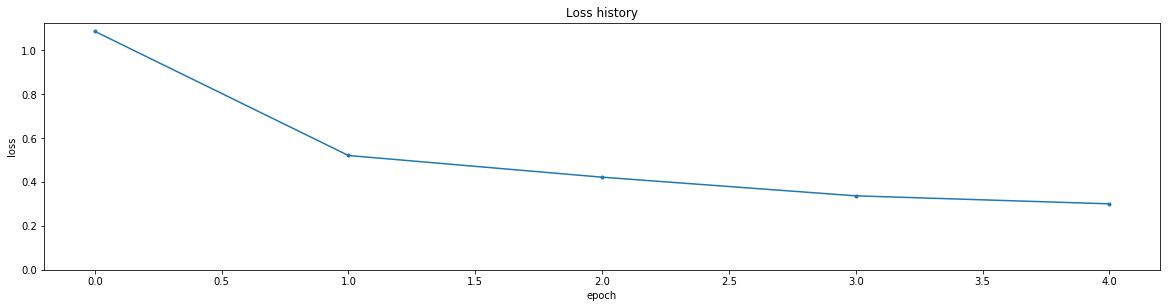

In [131]:
plot_loss(losses)

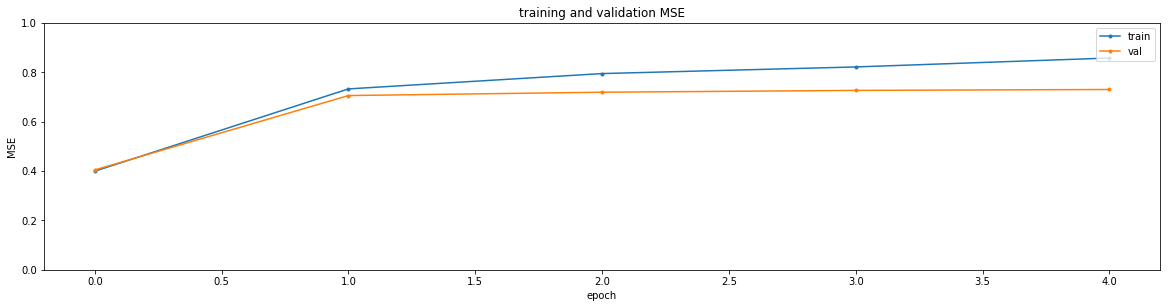

In [132]:
plot_accuracies(training_accuracy, validation_accuracy)

### pretrain 6k with data augmentation for 128 randomcrop 

In [119]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.4626
best training accuracy 0.7450
Best validation accuracy 0.7076


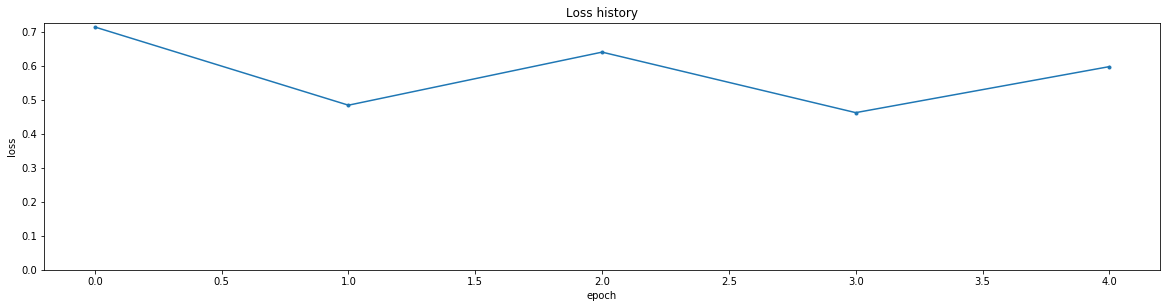

In [120]:
plot_loss(losses)

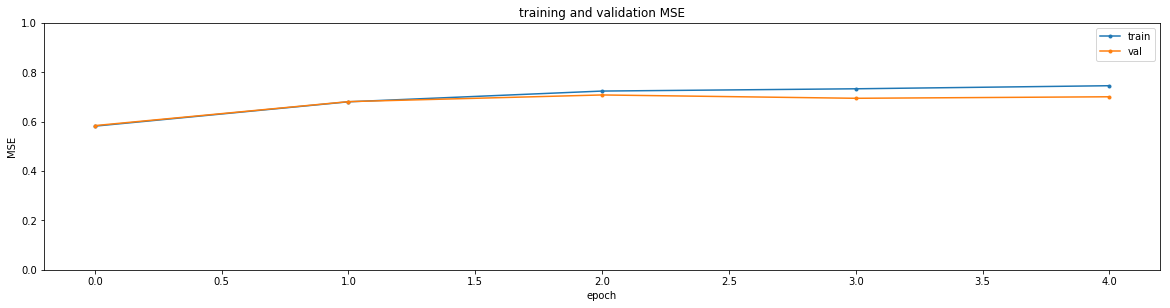

In [121]:
plot_accuracies(training_accuracy, validation_accuracy)

### Original Model for 6k with Bug fixing

In [35]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.2591
best training accuracy 0.8236
Best validation accuracy 0.7912


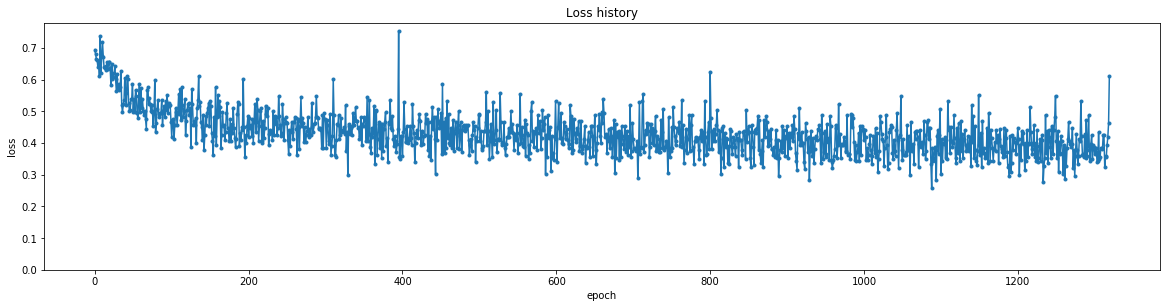

In [36]:
plot_loss(losses)

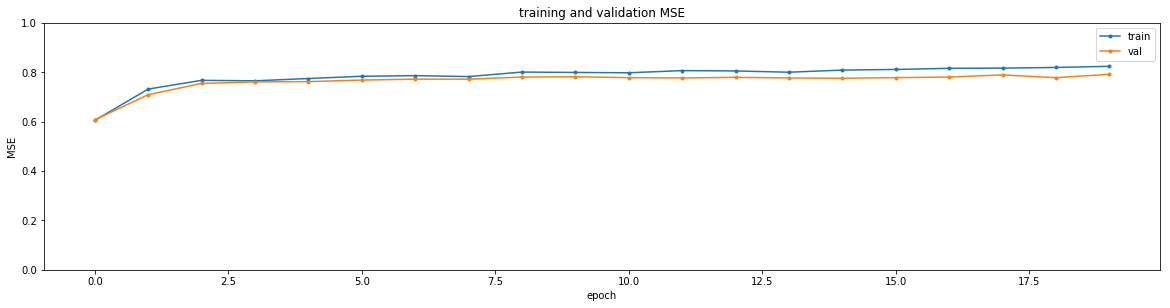

In [37]:
plot_accuracies(training_accuracy, validation_accuracy)

### Pre-train for 11.6k images include C2 

In [ ]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

In [25]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.0068
best training accuracy 0.9960
Best validation accuracy 0.7825


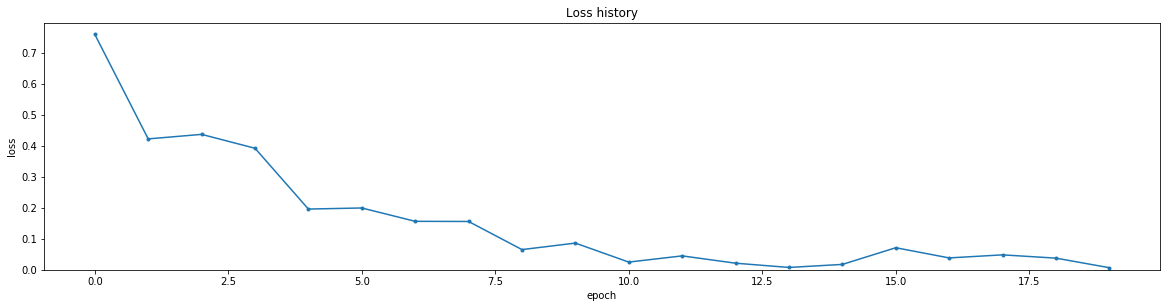

In [26]:
plot_loss(losses)

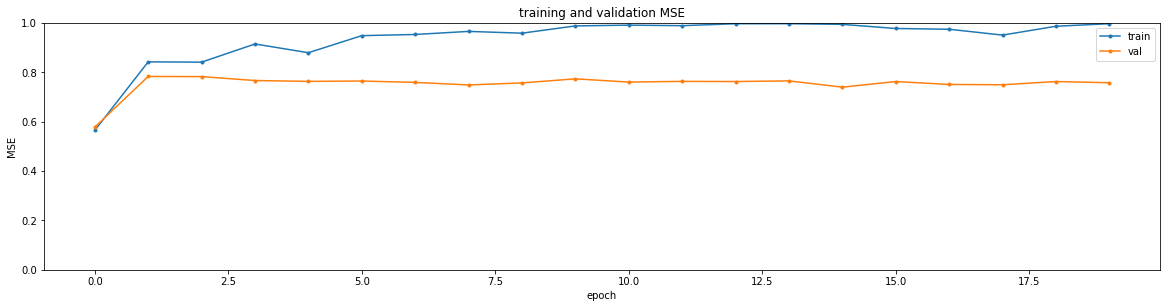

In [27]:
plot_accuracies(training_accuracy, validation_accuracy)

### Pre-train ResNet for 10k images

In [ ]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

In [ ]:
plot_loss(losses)

In [ ]:
plot_accuracies(training_accuracy, validation_accuracy)

### Pre-train model, with 3 days data, for 6510 images

In [55]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.0001
best training accuracy 1.0000
Best validation accuracy 0.8120


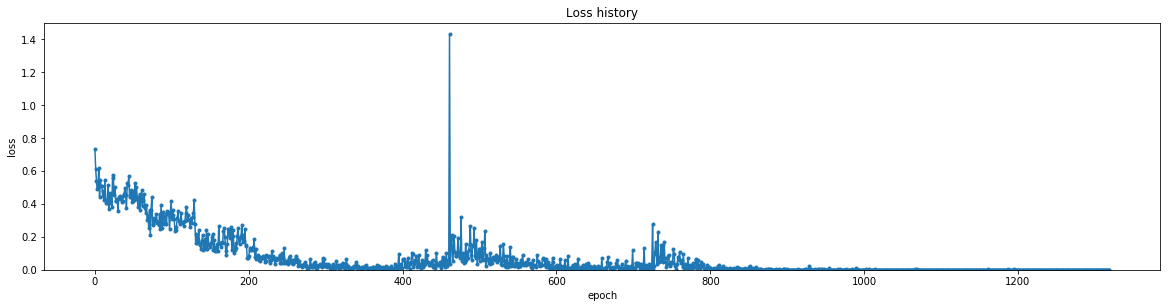

In [56]:
plot_loss(losses)

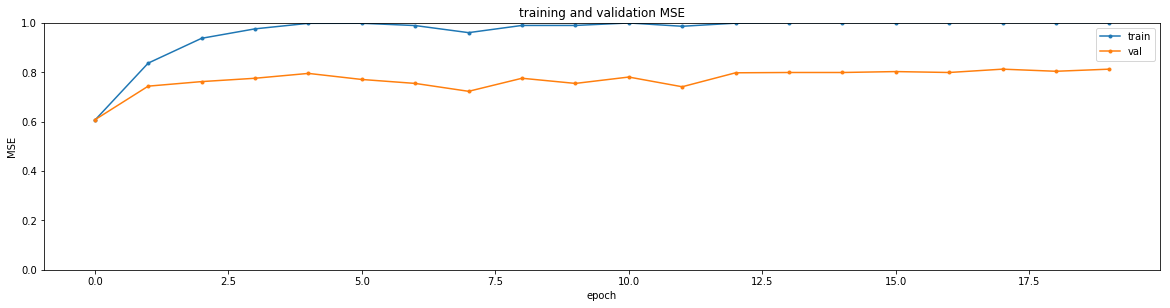

In [57]:
plot_accuracies(training_accuracy, validation_accuracy)

In [63]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.0001
best training accuracy 1.0000
Best validation accuracy 0.7887


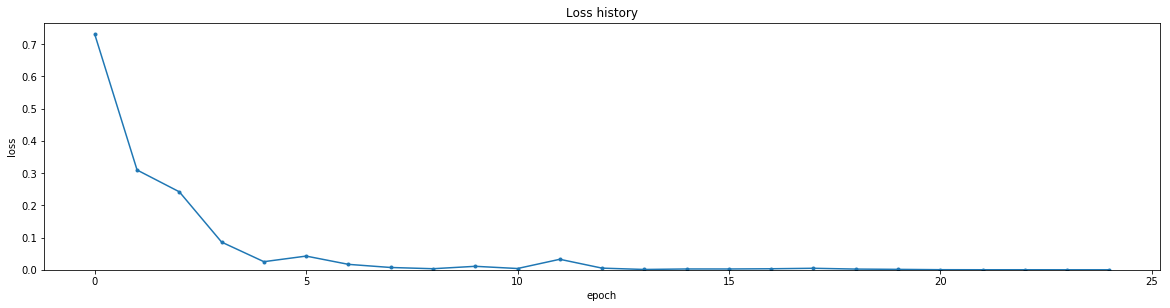

In [64]:
plot_loss(losses)

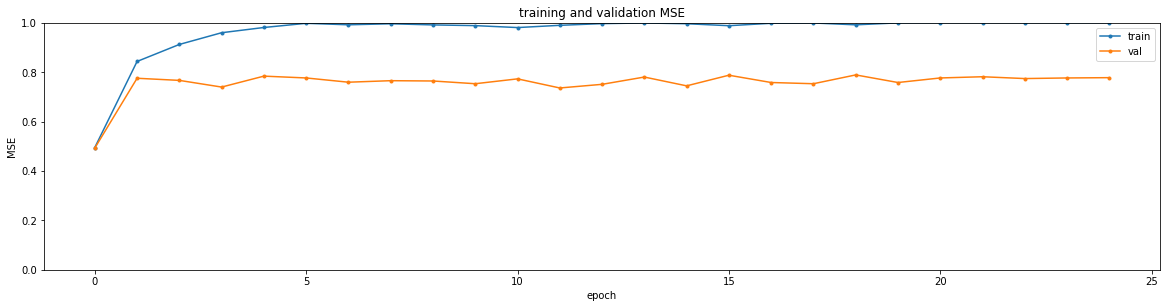

In [65]:
plot_accuracies(training_accuracy, validation_accuracy)

### Tain Shan's mode for 6k, add one more fully connected layer

In [29]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.2434
best training accuracy 0.8970
Best validation accuracy 0.8022


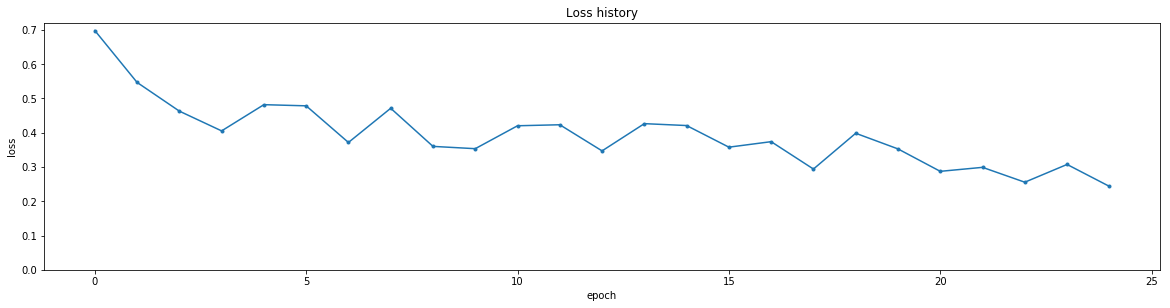

In [30]:
plot_loss(losses)

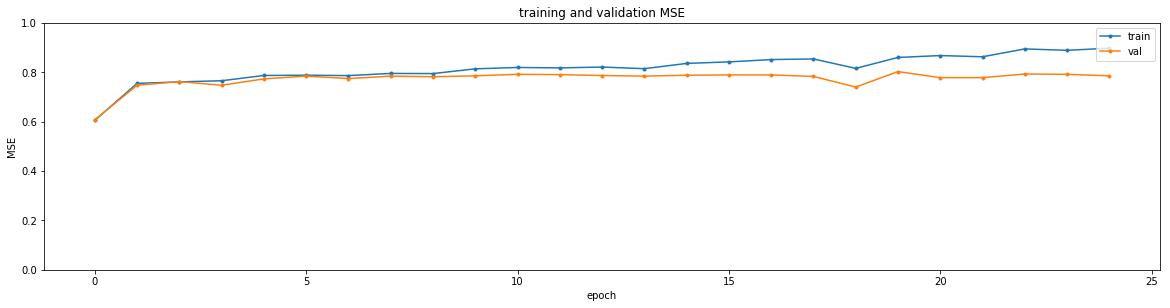

In [31]:
plot_accuracies(training_accuracy, validation_accuracy)

### Train Tim's model for 6k

In [23]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.1161
best training accuracy 0.9624
Best validation accuracy 0.7740


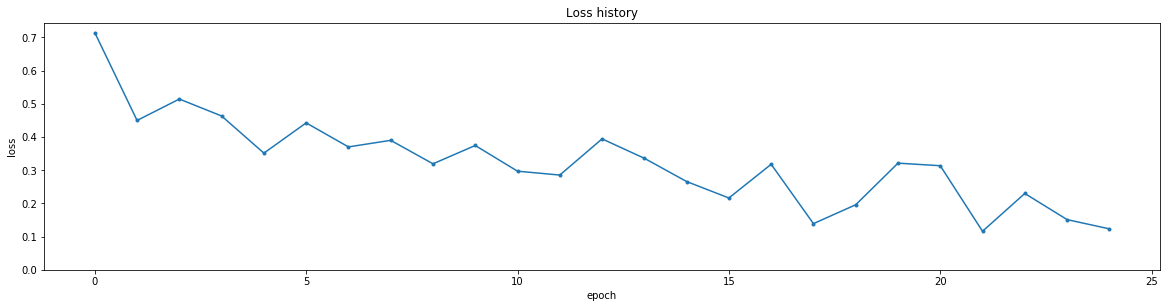

In [27]:
plot_loss(losses)

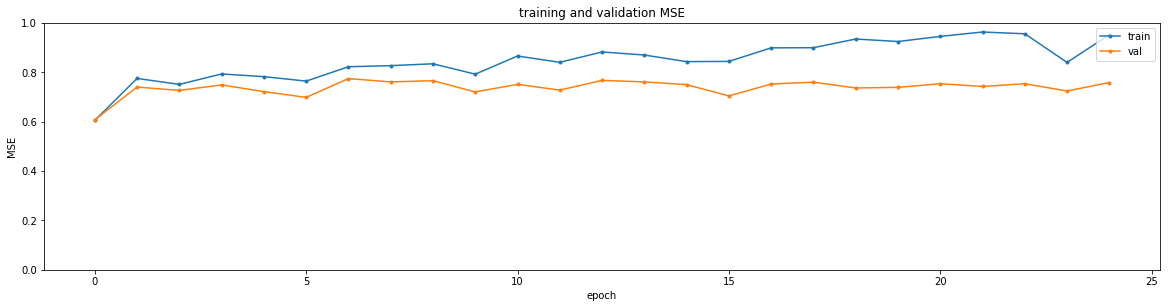

In [28]:
plot_accuracies(training_accuracy, validation_accuracy)

### train Tim's model for 10k

In [36]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

Minimum loss: 0.1510
best training accuracy 0.9399
Best validation accuracy 0.7742


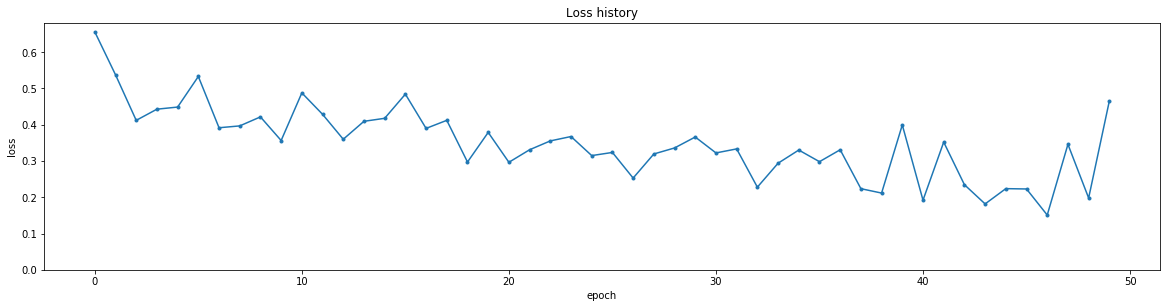

In [33]:
plot_loss(losses)

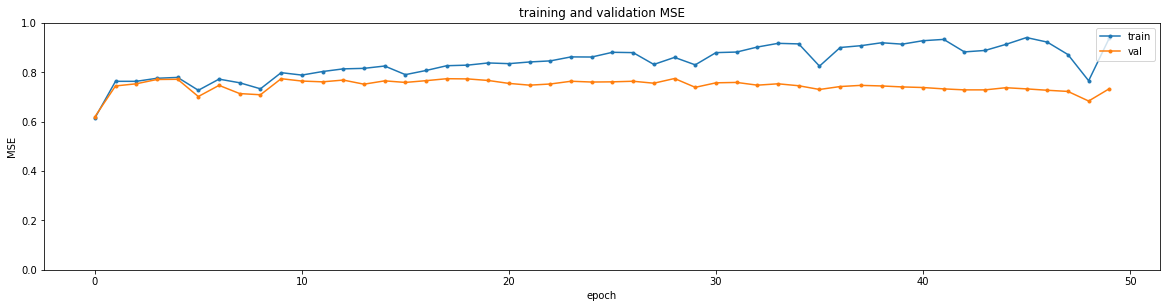

In [34]:
plot_accuracies(training_accuracy, validation_accuracy)

### 25 epoches for A1,A2,A3,A4,C1 10096 wells

In [ ]:
min_loss, best_val_acc, best_train_acc = print_best_loss_and_accuracy(losses,validation_accuracy,training_accuracy)

In [ ]:
plot_loss(losses)

In [ ]:
plot_accuracies(training_accuracy, validation_accuracy)

### 25 epoches for 6514

In [48]:
min(losses)

0.11285308003425598

In [49]:
max(validation_accuracy)

0.800982800982801

In [50]:
max(training_accuracy)

0.9158735032238257

In [54]:
len(losses)

1650

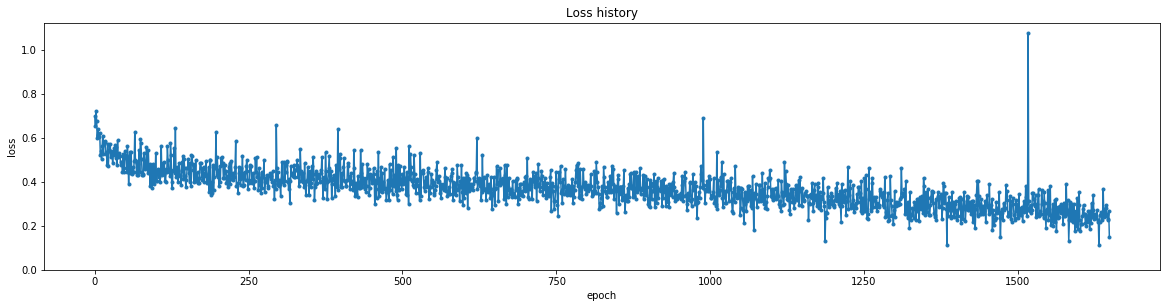

In [58]:
plot_loss(losses)

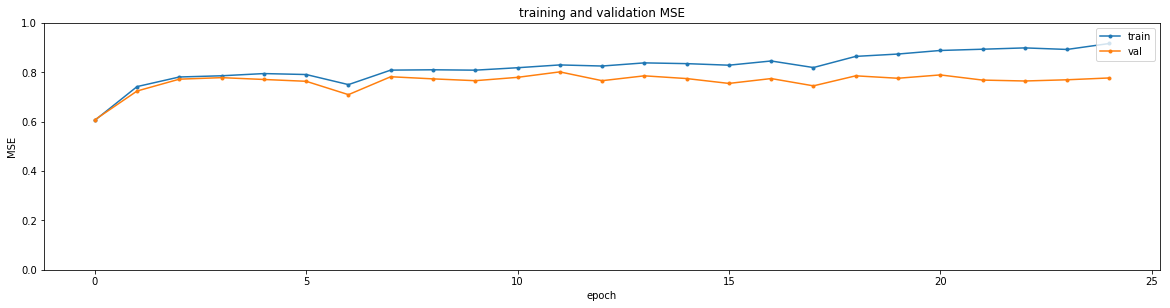

In [59]:
plot_accuracies(training_accuracy, validation_accuracy)

### 25 epoches for 4510 add dropout and one more maxpooling

In [79]:
losses[-1]

0.3849918842315674

In [80]:
validation_accuracy[-1]

0.6844050258684405

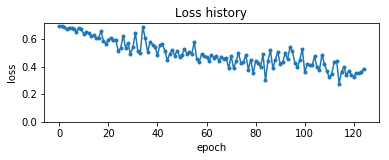

In [81]:
plot_loss(losses)

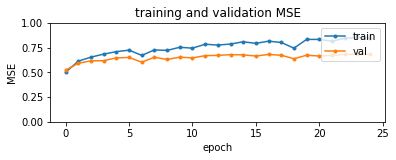

In [82]:
plot_accuracies(training_accuracy, validation_accuracy)

### 40 epoches for 4510 images

In [70]:
losses[-1]

0.005506948102265596

In [71]:
validation_accuracy[-1]

0.6560729243656073

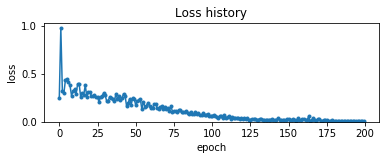

In [72]:
plot_loss(losses)

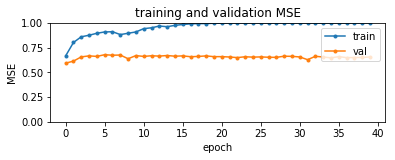

In [73]:
plot_accuracies(training_accuracy, validation_accuracy)

### 20 epoches for 4510 images

In [67]:
losses[-1]

0.19763290882110596

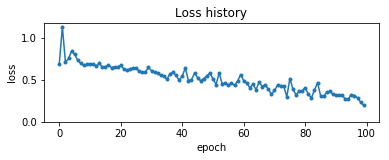

In [66]:
plot_loss(losses)

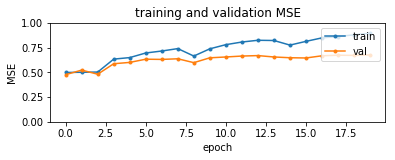

In [68]:
plot_accuracies(training_accuracy, validation_accuracy)

### 20 epoches for 100 samples, with more parameters in the model, lr 1e-4

1e-4 works better than 3e-4

In [46]:
losses

[0.03673647716641426,
 0.15473881363868713,
 0.03109760209918022,
 0.043180618435144424,
 0.08318685740232468,
 0.06350908428430557,
 0.03369792550802231,
 0.02246616780757904,
 0.025511790066957474,
 0.03427477553486824,
 0.03903079032897949,
 0.03526591137051582,
 0.026757724583148956,
 0.019364243373274803,
 0.01590343937277794,
 0.01624482497572899,
 0.018428007140755653,
 0.019507132470607758,
 0.01793486624956131,
 0.014654400758445263]

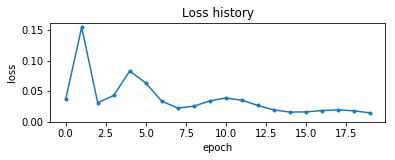

In [47]:
plot_loss(losses)

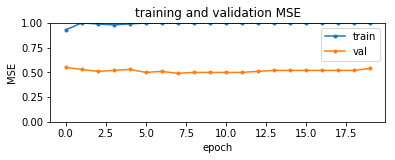

In [48]:
plot_accuracies(training_accuracy, validation_accuracy)

### 20 epoches for 100 samples, with more parameters in the model, lr 3e-4

In [44]:
losses

[0.4806969165802002,
 0.5153627991676331,
 0.5477129220962524,
 0.4509887397289276,
 0.3655143678188324,
 0.41471028327941895,
 0.3505489230155945,
 0.3003881573677063,
 0.29418376088142395,
 0.26897409558296204,
 0.22065502405166626,
 0.22278109192848206,
 0.16885076463222504,
 0.15301962196826935,
 0.12843157351016998,
 0.09845556318759918,
 0.09395033121109009,
 0.061386674642562866,
 0.06279673427343369,
 0.03890717029571533]

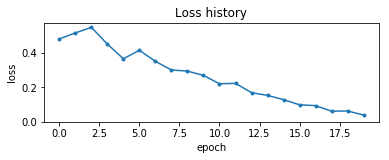

In [41]:
plot_loss(losses)

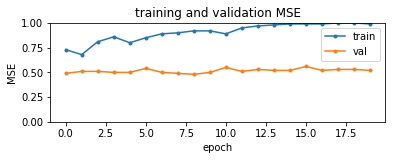

In [42]:
plot_accuracies(training_accuracy, validation_accuracy)

### 10 epoches for 100 samples, with more parameters in the model, lr 3e-4

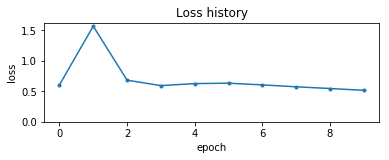

In [37]:
plot_loss(losses)

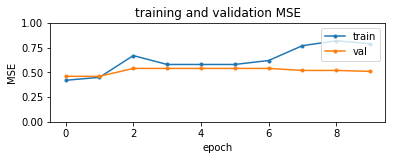

In [38]:
plot_accuracies(training_accuracy, validation_accuracy)

### 10 epoches for 100 samples, with more parameters in the model, lr 1e-4

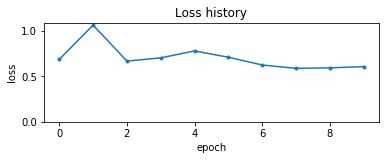

In [34]:
plot_loss(losses)

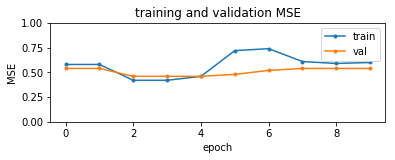

In [35]:
plot_accuracies(training_accuracy, validation_accuracy)

### 20 epoch for 100 samples

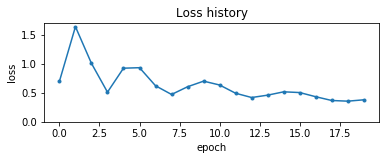

In [144]:
plot_loss(losses)

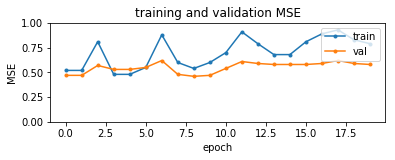

In [145]:
plot_accuracies(training_accuracy, validation_accuracy)

### 10 epoch for 100 samples

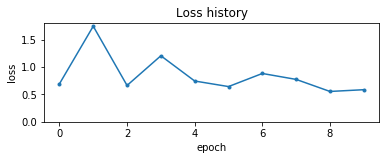

In [138]:
plot_loss()

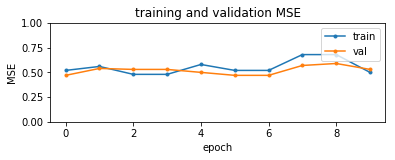

In [140]:
plot_accuracies(training_accuracy=training_accuracy, validation_accuracy=validation_accuracy)

# 10 Samples

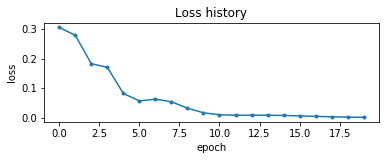

In [108]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(losses, '.-')
plt.title("Loss history")
#plt.ylim(0,3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

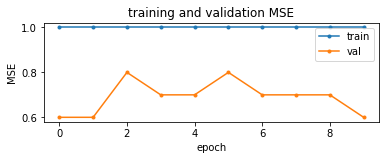

In [111]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(training_accuracy, '.-')
plt.plot(validation_accuracy, '.-')
plt.title("training and validation MSE")
#plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
#fig.savefig(figure_path+'train_val_MSE.pdf')